In [22]:
## NEW AND CLEAN NOTEBOOK, FINAL

In [23]:
!pip install pandas matplotlib datetime yfinance numpy scipy scikit-learn pandas_market_calendars numpy pycopula



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as DT
import yfinance as yf
import numpy as np 
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
import pandas_market_calendars as mcal
import datetime
import scipy as sp
import scipy.interpolate
from scipy.stats import norm
import math

import numpy as np
import pandas as pd
from scipy.stats import t, norm
from pycopula.copula import GaussianCopula

## Data Import

In [25]:
file_path = "../Data CSV/VIX.csv"
vix = pd.read_csv(file_path)
vix.set_index("Date", inplace = True)
vix.index = pd.DatetimeIndex(vix.index)
vix = vix["Price"]
vix.sort_index(ascending= False, inplace = True)

file_path = "../Data CSV/VSTOXX.csv"
vstoxx = pd.read_csv(file_path)
vstoxx.set_index("Date", inplace = True)
vstoxx.index = pd.DatetimeIndex(vstoxx.index)
vstoxx = vstoxx["Price"]
vstoxx.sort_index(ascending= False, inplace = True)


file_path = "../Data CSV/VSMI.csv"
vsmi = pd.read_csv(file_path)
x = np.array([(i.split(";")[0],i.split(";")[2]) for i in list(vsmi["Date;ISIN;Indexvalue"])])
x[:,1] = np.float16(x[:,1])
x[:,0] = [pd.to_datetime(i) for i in x[:,0]]
vsmi = pd.DataFrame(data= {"Price":np.float16(x[:,1])}, index= [pd.to_datetime(i) for i in x[:,0]])
vsmi.dropna(inplace= True)
vsmi.sort_index(ascending= False, inplace = True)

vol_index = {
    "SP500":vix, 
    "STOXX50": vstoxx, 
    "SMI": vsmi}


/var/folders/29/j6zpgq394917k8prm4sg190h0000gn/T/ipykernel_26508/407778646.py:20: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  x[:,0] = [pd.to_datetime(i) for i in x[:,0]]


In [26]:
final_date = pd.to_datetime('2024-09-26')
start_date = pd.to_datetime('2024-01-01')

def load_data(file_path):
    data = pd.read_csv(file_path)
    data.index = pd.to_datetime(data['Date'], format='%m/%d/%Y')
    data['Price'] = data['Price'].str.replace(',', '').astype(float)
    data['Log Return'] = np.log(data['Price'] / data['Price'].shift(1))
    data = data.dropna(subset=['Log Return'])
    data = data[data.index > "2020-01-01"]
    return data

file_path = "../Data CSV/SMI Historical Data.csv"
smi = load_data(file_path)

file_path = "../Data CSV/S&P 500 Historical Data.csv"
sp500 = load_data(file_path)

file_path = "../Data CSV/Euro Stoxx 50 Historical Data.csv"
stoxx50 = load_data(file_path)

common_dates = list(set(stoxx50.index).intersection(set(smi.index).intersection(set(sp500.index))))
## losing data on dates, simulation also assuming common dates, losing about 14% data
print("Data Loss:", (3*len(common_dates))/(len(stoxx50)+len(smi)+len(sp500)))

def load_data(file_path):
    data = pd.read_csv(file_path)
    data.index = pd.to_datetime(data['Date'], format='%m/%d/%Y')
    data = data[data.index.isin(common_dates)]
    data['Price'] = data['Price'].str.replace(',', '').astype(float)
    data['Log Return'] = np.log(data['Price'] / data['Price'].shift(1))
    data.drop(columns=["Change %"], errors = "Ignore", inplace = True)
    data = data.dropna(subset=['Log Return'])
    return data

file_path = "../Data CSV/SMI Historical Data.csv"
smi = load_data(file_path)

file_path = "../Data CSV/S&P 500 Historical Data.csv"
sp500 = load_data(file_path)

file_path = "../Data CSV/Euro Stoxx 50 Historical Data.csv"
stoxx50 = load_data(file_path)

returns = pd.DataFrame({
    'SMI': smi['Log Return'],
    'STOXX50': stoxx50['Log Return'],
    'SP500': sp500['Log Return']
}).dropna()

chf = pd.read_csv("../Data CSV/USD_CHF Historical Data.csv")
chf.index = pd.DatetimeIndex(chf["Date"])
eur = pd.read_csv("../Data CSV/USD_EUR Historical Data.csv")
eur.index = pd.DatetimeIndex(eur["Date"])

## Divide to convert chf to usd, multiply for other way 

dates = pd.bdate_range(start=start_date,end=final_date)

interest_rates = pd.read_excel("../Data CSV/US Interest Rates.xlsx")
interest_rates.columns = interest_rates.columns.str.strip()
interest_rates = interest_rates.dropna(subset=["United States Treasury 10-YR Rates"])
interest_rates["United States Treasury 10-YR Rates"] = pd.to_numeric(
    interest_rates["United States Treasury 10-YR Rates"], errors="coerce"
)
interest_rates.index = pd.DatetimeIndex(interest_rates["Dates"])
full_date_range = pd.date_range(start=interest_rates.index.min(), end=interest_rates.index.max())
interest_rates = interest_rates.reindex(full_date_range).ffill()
interest_rates.index.name = "Dates"
interest_rates.head()

r = interest_rates["United States Treasury 10-YR Rates"].dropna()
r = np.log(1+0.01*r)

sp500_init_level = 3977
stoxx_init_level_local = 4164
smi_init_level_local = 10786
##Double checked
dt = 1/252


Data Loss: 0.970348204570185


In [27]:
returns

SMI   STOXX50     SP500
Date                                    
2024-10-28  0.011291  0.003994 -0.001613
2024-10-25 -0.004420 -0.005395 -0.002648
2024-10-24 -0.000900 -0.001547  0.000300
2024-10-23 -0.002133 -0.002617 -0.002143
2024-10-22  0.001335  0.003399  0.009234
...              ...       ...       ...
2020-01-09  0.001078  0.001677  0.002875
2020-01-08  0.000112 -0.006162 -0.006618
2020-01-07  0.003247 -0.003534 -0.004900
2020-01-06 -0.002004 -0.001792  0.002807
2020-01-03  0.003221  0.005541 -0.003549

[1188 rows x 3 columns]

In [28]:
def calculate_pv_interest(start_date, risk_free_rate):
    
    payment_dates = pd.DatetimeIndex(['2023-07-03', '2023-10-03', '2024-01-03', '2024-04-03',
               '2024-07-03', '2024-10-03'],
              dtype='datetime64[ns]', freq=None)
    
    pv_interest = sum([
        1000 * 0.025 * math.exp(-risk_free_rate * ((payment_date - start_date).days / 365.0))
        for payment_date in payment_dates if payment_date > start_date
    ])
    
    return pv_interest

In [29]:
def price_barrier_reverse_convertible(start_date, price_paths ):
    final_date = pd.to_datetime('2024-09-26')
    start_date = pd.to_datetime(start_date)    
    T = (final_date - start_date).days / 365.0

    # Converting all the prices to USD
    eur_usd = eur["Price"][start_date] 
    chf_usd = chf["Price"][start_date] 
    stoxx_init_level = stoxx_init_level_local / eur_usd
    smi_init_level = smi_init_level_local / chf_usd
    sp500_barrier = sp500_init_level * 0.65
    stoxx_barrier = stoxx_init_level * 0.65
    smi_barrier = smi_init_level * 0.65
    
    payment_dates = [start_date + pd.DateOffset(months=3*i) for i in range(1, 5)]
    payment_dates = [d for d in payment_dates if d <= final_date]
    
    risk_free_rate = r[r.index <= start_date].iloc[-1]

    pv_interest = calculate_pv_interest(start_date, risk_free_rate)
    
    discount_factor_maturity = math.exp(-risk_free_rate * T)
    
    sim_dates = pd.bdate_range(start=start_date, end=final_date)
    sim_length = len(sim_dates)
    
    num_sims = len(price_paths['SMI'])
    
    prices = np.zeros(num_sims)
    for i in range(num_sims):
        sim_SMI = np.array(price_paths['SMI'][i][:sim_length])
        sim_SP500 = np.array(price_paths['SP500'][i][:sim_length])
        sim_STOXX50 = np.array(price_paths['STOXX50'][i][:sim_length])
        
        barrier_breached = (
            (sim_SMI < smi_barrier).any() or
            (sim_SP500 < sp500_barrier).any() or
            (sim_STOXX50 < stoxx_barrier).any()
        )
        
        if not barrier_breached:
            pv_redemption = 1000 * discount_factor_maturity
        else:
            
            final_SMI = sim_SMI[-1]
            final_SP500 = sim_SP500[-1]
            final_STOXX50 = sim_STOXX50[-1]
            
            perf_SMI = final_SMI / smi_init_level
            perf_SP500 = final_SP500 / sp500_init_level
            perf_STOXX50 = final_STOXX50 / stoxx_init_level
            worst_perf = min(perf_SMI, perf_SP500, perf_STOXX50, 1)
            pv_redemption = 1000 * discount_factor_maturity * worst_perf 
        price = pv_interest + pv_redemption
        prices[i] = price    
    return prices

## Different models

In [30]:
sigma = {}
for index in ['SMI', 'STOXX50', 'SP500']:
    variance = returns[index].var(ddof= 1)*252
    sigma[index] = np.sqrt(variance)


corr_matrix = returns.corr()
chol_matrix = np.linalg.cholesky(corr_matrix)

price_data = {
        'SMI': smi,
        'STOXX50': stoxx50,
        'SP500': sp500
    }
indices = ['SMI', 'STOXX50', 'SP500']

In [31]:
def simulate_gbm(start_date, n_simulations = 100000, verbose = False, h_percentage_change = {'SMI': 1.0,'STOXX50':1.0, 'SP500':1.0}):
    dt = 1 / 252  
    
    risk_free_rate = r[r.index <= start_date].iloc[-1]
    n_timesteps = len(dates)

    Z = np.random.normal(size=(n_timesteps, n_simulations, 3))
    Z_flat = Z.reshape(-1, 3)
    Z_correlated_flat = Z_flat @ chol_matrix.T
    Z_correlated = Z_correlated_flat.reshape(n_timesteps, n_simulations, 3)
    initial_prices = {}
    for index in indices:
        initial_prices[index] = price_data[index]['Price'][price_data[index].index >= start_date].iloc[-1]
    for i in indices:
        initial_prices[i] *= h_percentage_change.get(i)

    
    price_paths = {
        'SMI': np.zeros((n_timesteps + 1, n_simulations)),
        'STOXX50': np.zeros((n_timesteps + 1, n_simulations)),
        'SP500': np.zeros((n_timesteps + 1, n_simulations))
    }
    
    for index in ['SMI', 'STOXX50', 'SP500']:
        price_paths[index][0] = initial_prices[index]
    
    for i in range(1, n_timesteps + 1):
        for idx, index in enumerate(['SMI', 'STOXX50', 'SP500']):
            drift_term = (risk_free_rate - 0.5 * sigma[index] ** 2)*dt
            diffusion_term = sigma[index] * np.sqrt(dt) * Z_correlated[i - 1, :, idx]
            price_paths[index][i] = price_paths[index][i - 1] * np.exp(drift_term + diffusion_term)
    
    for index in ['SMI', 'STOXX50', 'SP500']:
        price_paths[index]= price_paths[index].transpose()
    T = (final_date-start_date).days/352
    if not verbose:
        return price_paths
    
    for i in price_paths:
        print(i)
        paths = price_paths.get(i)
        print("| Mean Price:", np.mean([i[-1] for i in paths]), "| Mean Return:", np.mean([i[-1] for i in paths])/paths[0][0], "| SD of Return:", np.std(np.array([i[-1] for i in paths])/paths[0][0]))
    return price_paths

In [32]:
# Define the negative log-likelihood function. Here we fix theta to be 3.84%, according to US Long-Term Monthly Rate Analysis
def negative_log_likelihood_fixed_theta(params, r_df, theta=0.0384):
    kappa, sigma_r = params
    if kappa <= 0 or sigma_r <= 0:
        return np.inf
    log_likelihood = 0
    rates = r_df.values
    dates = r_df.index
    for t in range(len(rates) - 1):
        r_t = rates[t]
        r_t1 = rates[t + 1]
        dr = r_t1 - r_t
        dt_days = (dates[t + 1] - dates[t]).days
        dt = dt_days / 252
        if dt <= 0:
            continue
        mean_increment = kappa * (theta - r_t) * dt
        variance_increment = sigma_r**2 * r_t * dt
        if variance_increment <= 0:
            return np.inf
        likelihood_t = -0.5 * np.log(2 * np.pi * variance_increment) - 0.5 * (
            (dr - mean_increment) ** 2 / variance_increment
        )
        log_likelihood += likelihood_t
    return -log_likelihood

# Initial guesses and bounds for kappa and sigma_r
initial_vals = [0.1, np.std(r.values)]
bounds = ((1e-5, None), (1e-5, None))

# Optimization with fixed theta
result = scipy.optimize.minimize(
    negative_log_likelihood_fixed_theta, initial_vals, args=(r,dt), bounds=bounds, method="L-BFGS-B"
)

kappa, sigma_r = result.x
theta = np.log(1+0.0384)
print("Fitted Parameters with Theta Fixed at 0.0384:")
print("kappa:", kappa)
print("sigma_r:", sigma_r)
print("theta:", theta)



Fitted Parameters with Theta Fixed at 0.0384:
kappa: 1e-05
sigma_r: 0.05580666435095845
theta: 0.037681066967688484


In [33]:
import pandas as pd

def load_data(file_path, date_column='Period'):
    """
    Load CSV data, parse the date column, and return a DataFrame.

    Parameters:
    - file_path (str): Path to the CSV file.
    - date_column (str): Column name containing date information.

    Returns:
    - pd.DataFrame: Loaded and processed DataFrame.
    """
    try:
        data = pd.read_csv(file_path)
        if date_column in data.columns:
            data[date_column] = pd.to_datetime(data[date_column])
            data.set_index(date_column, inplace=True)
        else:
            print(f"Warning: '{date_column}' column not found in {file_path}")
        return data
    except FileNotFoundError:
        print(f"Error: File not found - {file_path}")
        return pd.DataFrame()
    except Exception as e:
        print(f"Error: An error occurred while loading {file_path} - {e}")
        return pd.DataFrame()

## Load datasets with correct assignments
smi_file_path = "../Data CSV/SwitzerlandMarkov.csv"
smi_markov = load_data(smi_file_path)

sp500_file_path = "../Data CSV/USAMarkov.csv"
sp500_markov = load_data(sp500_file_path)

stoxx50_file_path = "../Data CSV/EurozoneMarkov.csv"
stoxx50_markov = load_data(stoxx50_file_path)

# Display one of the datasets
print("smi markov:")
print(smi_markov)
print("sp500:")
print(sp500_markov)
print("stoxx50:")
print(stoxx50_markov)

# Reindex the 'Combined_Regime' to daily frequency, forward-filling
smi_regime_daily = smi_markov['Combined_Regime'].reindex(returns.index, method='ffill')
sp500_regime_daily = sp500_markov['Combined_Regime'].reindex(returns.index, method='ffill')
stoxx50_regime_daily = stoxx50_markov['Combined_Regime'].reindex(returns.index, method='ffill')

# Add the regimes to the returns DataFrame
returns['SMI_Regime'] = smi_regime_daily
returns['SP500_Regime'] = sp500_regime_daily
returns['STOXX50_Regime'] = stoxx50_regime_daily

# Drop rows with missing regime data
returns.dropna(subset=['SMI_Regime', 'SP500_Regime', 'STOXX50_Regime'], inplace=True)

smi markov:
            GDP_YoY%  CPI_YoY%  Combined_Regime
Period                                         
2000-03-31    0.0432      1.48                2
2000-04-30    0.0432      1.40                2
2000-05-31    0.0432      1.58                2
2000-06-30    0.0410      1.84                2
2000-07-31    0.0410      1.89                2
...              ...       ...              ...
2024-04-30    0.0074      1.37                1
2024-05-31    0.0074      1.39                1
2024-06-30    0.0169      1.33                1
2024-07-31    0.0169      1.29                1
2024-08-31    0.0169      1.06                1

[294 rows x 3 columns]
sp500:
            GDP_YoY%  CPI_YoY%  Combined_Regime
Period                                         
2000-03-31    0.0422      3.76                4
2000-04-30    0.0422      3.07                4
2000-05-31    0.0422      3.19                4
2000-06-30    0.0524      3.73                4
2000-07-31    0.0524      3.66               

In [34]:
def simulate_price_paths_with_CIR(start_date, n_simulations, h_percentage_change = {'SMI': 1.0,'STOXX50':1.0, 'SP500':1.0}):
    start_date = pd.to_datetime(start_date)
    final_date = pd.to_datetime('2024-09-26')
  
    sim_dates = pd.bdate_range(start=start_date, end=final_date)
    n_timesteps = len(sim_dates)

    corr_matrix = returns[indices].corr()
    chol_matrix = np.linalg.cholesky(corr_matrix)

    Z = np.random.normal(size=(n_timesteps, n_simulations, len(indices)))
    Z_flat = Z.reshape(-1, len(indices))
    Z_correlated_flat = Z_flat @ chol_matrix.T
    Z_correlated = Z_correlated_flat.reshape(n_timesteps, n_simulations, len(indices))
    initial_prices = {}
    
    for index in indices:
        initial_prices[index] = price_data[index]['Price'][price_data[index].index >= start_date].iloc[-1]
    for i in indices:
        initial_prices[i] *= h_percentage_change.get(i)

    price_paths = {index: np.zeros((n_timesteps + 1, n_simulations)) for index in ['SMI', 'STOXX50', 'SP500']}
    for index in ['SMI', 'STOXX50', 'SP500']:
        price_paths[index][0] = initial_prices[index]
    
    initial_rate = r[start_date]

    r_paths = np.zeros((n_timesteps + 1, n_simulations))
    # r_paths = r_paths.T  # Shape: (n_simulations, n_timesteps + 1)
    r_paths[0, :] = initial_rate
    
    
    for i in range(1, n_timesteps + 1):
        Z_r = np.random.normal(size=n_simulations)
        r_t_prev = r_paths[i - 1]
        dr = kappa * (theta - r_t_prev) * dt + sigma_r * np.sqrt(r_t_prev * dt) * Z_r
        r_paths[i] = np.maximum(r_t_prev + dr, 0)
        
    
        for idx, index in enumerate(['SMI', 'STOXX50', 'SP500']):
            drift_term = (r_paths[i] - 0.5 * sigma[index] ** 2) * dt
            # drift_term = (np.log(1+r_paths[i]*0.01) - 0.5 * sigma[index] ** 2) * dt
            diffusion_term = sigma[index] * np.sqrt(dt) * Z_correlated[i - 1, :, idx]
            price_paths[index][i] = price_paths[index][i - 1] * np.exp(drift_term + diffusion_term)
    
    for index in ['SMI', 'STOXX50', 'SP500']:
        price_paths[index] = price_paths[index].transpose()
    return price_paths, r_paths


In [ ]:
def simulate_gbm_with_av(start_date, n_simulations=100000, verbose=False):
    # Define parameters and settings
    final_date = pd.to_datetime('2024-09-26')
    start_date = pd.to_datetime(start_date)
    dt = 1/252
    trading_days = pd.bdate_range(start=start_date, end="2024-01-01")
    n_timesteps = len(trading_days) - 1

    initial_prices = {}
    for index in indices:
        initial_prices[index] = price_data[index]['Price'][price_data[index].index >= start_date].iloc[-1]

    # Generate random variables for asset price simulation
    Z = np.random.normal(size=(n_timesteps, n_simulations, 3))
    Z_antithetic = -Z

    # Flatten and correlate the random variables
    Z_flat = Z.reshape(-1, 3)
    Z_antithetic_flat = Z_antithetic.reshape(-1, 3)

    Z_correlated_flat = Z_flat @ chol_matrix.T
    Z_correlated = Z_correlated_flat.reshape(n_timesteps, n_simulations, 3)
    Z_correlated_antithetic_flat = Z_antithetic_flat @ chol_matrix.T
    Z_correlated_antithetic = Z_correlated_antithetic_flat.reshape(n_timesteps, n_simulations, 3)

    # Initialize price paths
    price_paths = {index: np.zeros((n_simulations, n_timesteps + 1)) for index in indices}
    for index in indices:
        price_paths[index][:, 0] = initial_prices[index]

    initial_rate = r[start_date]
    print("Initial Interest Rate:", initial_rate)

    r_paths = np.zeros((n_simulations, n_timesteps + 1))
    r_paths[:, 0] = initial_rate

    # Define mean interest rate for control variate
    mean_r = theta

    # Initialize control variate paths
    # control_variate_paths = {index: np.zeros((n_simulations, n_timesteps + 1)) for index in indices}
    # for index in indices:
    #     control_variate_paths[index][:, 0] = initial_prices[index]

    # Main simulation loop
    for i in range(1, n_timesteps + 1):
        # Random shocks for interest rates (using antithetic variates)
        Z_r = np.random.normal(size=n_simulations // 2)

        r_t_prev_regular = r_paths[:n_simulations // 2, i - 1]
        r_t_prev_antithetic = r_paths[n_simulations // 2:, i - 1]

        sqrt_r_t_prev_regular = np.sqrt(np.maximum(r_t_prev_regular, 0))
        sqrt_r_t_prev_antithetic = np.sqrt(np.maximum(r_t_prev_antithetic, 0))

        dr_regular = (kappa * (theta - r_t_prev_regular) * dt +
                      sigma_r * sqrt_r_t_prev_regular * np.sqrt(dt) * Z_r)
        dr_antithetic = (kappa * (theta - r_t_prev_antithetic) * dt +
                         sigma_r * sqrt_r_t_prev_antithetic * np.sqrt(dt) * -Z_r)

        r_paths[:n_simulations // 2, i] = np.maximum(r_t_prev_regular + dr_regular, 0)
        r_paths[n_simulations // 2:, i] = np.maximum(r_t_prev_antithetic + dr_antithetic, 0)

        # Simulate asset price paths
        for idx, index in enumerate(indices):
            # Drift terms with stochastic interest rates
            drift_term_regular = (r_paths[:n_simulations // 2, i] - 0.5 * sigma[index] ** 2) * dt
            drift_term_antithetic = (r_paths[n_simulations // 2:, i] - 0.5 * sigma[index] ** 2) * dt

            # Diffusion terms
            diffusion_term_regular = sigma[index] * np.sqrt(dt) * Z_correlated[i - 1, :n_simulations // 2, idx]
            diffusion_term_antithetic = sigma[index] * np.sqrt(dt) * Z_correlated_antithetic[i - 1, n_simulations // 2:, idx]

            # Update price paths with corrected indexing
            price_paths[index][:n_simulations // 2, i] = (
                price_paths[index][:n_simulations // 2, i - 1] *
                np.exp(drift_term_regular + diffusion_term_regular)
            )
            price_paths[index][n_simulations // 2:, i] = (
                price_paths[index][n_simulations // 2:, i - 1] *
                np.exp(drift_term_antithetic + diffusion_term_antithetic)
            )

            # # Drift term with constant mean interest rate for control variate
            # drift_term_cv = (mean_r - 0.5 * sigma[index] ** 2) * dt

            # # Update control variate paths
            # control_variate_paths[index][:n_simulations // 2, i] = (
            #     control_variate_paths[index][:n_simulations // 2, i - 1] *
            #     np.exp(drift_term_cv + diffusion_term_regular)
            # )
            # control_variate_paths[index][n_simulations // 2:, i] = (
            #     control_variate_paths[index][n_simulations // 2:, i - 1] *
            #     np.exp(drift_term_cv + diffusion_term_antithetic)
            # )

    # # Apply control variate adjustment and calculate variance reduction
    # for index in indices:
    #     final_prices = price_paths[index][:, -1]
    #     control_variate_final = control_variate_paths[index][:, -1]

    #     # Calculate the expected final price analytically
    #     T = n_timesteps * dt
    #     mu = mean_r - 0.5 * sigma[index] ** 2
    #     E_S_T = initial_prices[index] * np.exp(mu * T)

    #     # Compute covariance and variance
    #     cov_matrix = np.cov(final_prices, control_variate_final)
    #     C = -cov_matrix[0, 1] / cov_matrix[1, 1]

    #     # Apply control variate adjustment
    #     price_paths[index][:, -1] += C * (E_S_T - control_variate_final)

    #     if verbose:
    #         # Calculate variances for variance reduction report
    #         var_without_av = np.var(price_paths[index][:n_simulations // 2, -1])
    #         var_with_av = np.var(price_paths[index][:, -1])
    #         reduction_factor = var_without_av / var_with_av

    #         print(f"\nIndex: {index}")
    #         print(f"Variance without Antithetic Variates: {var_without_av:.4f}")
    #         print(f"Variance with Antithetic Variates: {var_with_av:.4f}")
    #         print(f"Variance Reduction Factor: {reduction_factor:.2f}")

    return price_paths

In [ ]:
assets = ['SMI', 'SP500', 'STOXX50']
regime_params = {}

for asset in assets:
    regime_params[asset] = {}
    for regime in returns[asset + '_Regime'].unique():
        mask = returns[asset + '_Regime'] == regime
        returns_in_regime = returns.loc[mask, asset]
        mean_return = returns_in_regime.mean() * 252  # Annualized mean return
        volatility = returns_in_regime.std() * np.sqrt(252)  # Annualized volatility
        regime_params[asset][regime] = {
            'mean_return': mean_return,
            'volatility': volatility
        }

transition_matrices = {}

for asset in assets:
    regimes = sorted(returns[asset + '_Regime'].unique())
    n_regimes = len(regimes)
    counts = np.zeros((n_regimes, n_regimes))
    total_counts = np.zeros(n_regimes)

    asset_regimes = returns[asset + '_Regime'].values.astype(int)
    for t in range(len(asset_regimes) - 1):
        current_regime = asset_regimes[t] - 1  # Adjusting for zero-based indexing
        next_regime = asset_regimes[t + 1] - 1
        counts[current_regime, next_regime] += 1
        total_counts[current_regime] += 1

    transition_matrix = counts / total_counts[:, None]
    transition_matrices[asset] = np.nan_to_num(transition_matrix)
    
def simulate_price_paths_with_regime_switching(start_date, end_date, n_simulations):
    """
    Simulate price paths with regime switching from start_date to end_date.

    Parameters:
    - start_date (str or pd.Timestamp): The date from which the simulation starts.
    - end_date (str or pd.Timestamp): The date at which the simulation ends.
    - n_simulations (int): Number of simulation paths.

    Returns:
    - price_paths (dict): Dictionary with asset names as keys and arrays of shape
      (n_simulations, n_days) as values containing simulated price paths.
    """

    # Define assets
    assets = ['SMI', 'SP500', 'STOXX50']

    # Calculate the number of time steps based on business days
    n_timesteps = len(pd.bdate_range(start=start_date, end=end_date))

    # Initialize regime paths
    regime_paths = {}

    # Ensure returns DataFrame is sorted by index
    if not returns.index.is_monotonic_increasing:
        returns_sorted = returns.sort_index()
    else:
        returns_sorted = returns.copy()

    for asset in assets:
        # Get the transition matrix for the asset
        transition_matrix = transition_matrices[asset]

        # Initialize regime paths for each asset
        regime_paths[asset] = np.zeros((n_simulations, n_timesteps), dtype=int)

        # Set the initial regime based on the last known regime before the start date
        start_date_ts = pd.to_datetime(start_date)

        # Ensure start_date is within the index range
        if start_date_ts < returns_sorted.index.min():
            raise ValueError(f"start_date {start_date} is before the earliest date in returns data.")

        # Get all dates up to and including start_date
        dates_up_to_start = returns_sorted.index[returns_sorted.index <= start_date_ts]

        if len(dates_up_to_start) == 0:
            raise ValueError(f"No data available up to start_date {start_date}")

        # Get the last available date up to start_date
        last_available_date = dates_up_to_start[-1]

        # Retrieve the initial regime
        initial_regime_value = returns_sorted.loc[last_available_date, asset + '_Regime']

        # Handle the case where initial_regime_value might be a Series
        if isinstance(initial_regime_value, pd.Series):
            initial_regime_value = initial_regime_value.iloc[-1]

        initial_regime = int(initial_regime_value) - 1  # Zero-based indexing
        regime_paths[asset][:, 0] = initial_regime

        # Simulate regime paths
        for t in range(1, n_timesteps):
            current_regimes = regime_paths[asset][:, t - 1]
            probs = transition_matrix[current_regimes]
            random_values = np.random.rand(n_simulations)
            cumulative_probs = probs.cumsum(axis=1)
            next_regimes = (random_values[:, None] < cumulative_probs).argmax(axis=1)
            regime_paths[asset][:, t] = next_regimes

    # Assign volatility based on the regimes (no longer assigning drift)
    volatility = {}

    for asset in assets:
        volatility[asset] = np.zeros((n_simulations, n_timesteps))
        for regime in regime_params[asset]:
            mask = regime_paths[asset] == (regime - 1)
            volatility_value = regime_params[asset][regime]['volatility']
            volatility[asset][mask] = volatility_value

    # Retrieve the initial interest rate before the start date
    # Ensure r is sorted by index
    if not r.index.is_monotonic_increasing:
        r_sorted = r.sort_index()
    else:
        r_sorted = r.copy()

    # Ensure start_date is within the index range
    if start_date_ts < r_sorted.index.min():
        raise ValueError(f"start_date {start_date} is before the earliest date in interest rate data.")

    # Get all dates up to and including start_date
    dates_up_to_start_r = r_sorted.index[r_sorted.index <= start_date_ts]

    if len(dates_up_to_start_r) == 0:
        raise ValueError(f"No interest rate data available up to start_date {start_date}")

    # Get the last available date up to start_date
    last_available_date_r = dates_up_to_start_r[-1]

    # Retrieve the initial interest rate
    initial_rate_value = r_sorted.loc[last_available_date_r]

    # Handle the case where initial_rate_value might be a Series
    if isinstance(initial_rate_value, pd.Series):
        initial_rate_value = initial_rate_value.iloc[0]

    initial_rate = initial_rate_value

    # Initialize interest rate paths
    r_paths = np.zeros((n_simulations, n_timesteps))
    r_paths[:, 0] = initial_rate

    # Initialize price paths
    initial_prices = {'SMI': 1000, 'STOXX50': 3500, 'SP500': 4500}
    price_paths = {index: np.zeros((n_simulations, n_timesteps)) for index in assets}
    for index in assets:
        price_paths[index][:, 0] = initial_prices[index]

    # Generate the Cholesky decomposition of the correlation matrix
    corr_matrix = returns[assets].corr()
    chol_matrix = np.linalg.cholesky(corr_matrix)

    epsilon = 1e-6  # Small number to prevent division by zero

    # Simulation loop
    for t in range(1, n_timesteps):
        # Simulate interest rates
        Z_r = np.random.normal(size=n_simulations)
        r_t_prev = r_paths[:, t - 1]
        dr = (kappa * (theta - r_t_prev) * dt +
              sigma_r * np.sqrt(np.maximum(r_t_prev, 0)) * np.sqrt(dt) * Z_r)
        r_t = np.maximum(r_t_prev + dr, 0)
        r_paths[:, t] = r_t

        # Generate correlated random variables
        Z = np.random.normal(size=(n_simulations, len(assets)))
        Z_correlated = Z @ chol_matrix.T

        for idx, asset in enumerate(assets):
            # Retrieve volatility
            volatility_t = volatility[asset][:, t - 1]
            # Use the risk-free rate as the drift
            drift_t = r_t  # r_t is of shape (n_simulations,)

            # Calculate drift term using the risk-free interest rate
            drift_term = (drift_t - 0.5 * volatility_t ** 2) * dt

            # Calculate diffusion term
            diffusion_term = volatility_t * np.sqrt(dt) * Z_correlated[:, idx]

            # Update asset prices
            price_paths[asset][:, t] = price_paths[asset][:, t - 1] * np.exp(drift_term + diffusion_term)

    return price_paths

In [37]:
import numpy as np
import pandas as pd

# Time parameters
final_date = '2024-09-26'
start_date = '2023-09-01'
dt = 1/252  # Assuming 252 trading days in a year
n_simulations = 10000
n_timesteps = len(pd.bdate_range(start=start_date, end='2024-01-01'))

initial_prices = {}
for index in indices:
    initial_prices[index] = price_data[index]['Price'][price_data[index].index >= start_date].iloc[-1]

# Generate random variables for asset price simulation
Z = np.random.normal(size=(n_timesteps, n_simulations, 3))
Z_antithetic = -Z

# Flatten and correlate the random variables
Z_flat = Z.reshape(-1, 3)
Z_antithetic_flat = Z_antithetic.reshape(-1, 3)

Z_correlated_flat = Z_flat @ chol_matrix.T
Z_correlated = Z_correlated_flat.reshape(n_timesteps, n_simulations, 3)
Z_correlated_antithetic_flat = Z_antithetic_flat @ chol_matrix.T
Z_correlated_antithetic = Z_correlated_antithetic_flat.reshape(n_timesteps, n_simulations, 3)

# Trim dataframes to start date
smi = smi[smi['Date'] >= start_date]
sp500 = sp500[sp500['Date'] >= start_date]
stoxx50 = stoxx50[stoxx50['Date'] >= start_date]

# Initialize price paths
price_paths = {index: np.zeros((n_simulations, n_timesteps + 1)) for index in ['SMI', 'STOXX50', 'SP500']}
for index in ['SMI', 'STOXX50', 'SP500']:
    price_paths[index][:, 0] = initial_prices[index]

# Initialize interest rate paths
initial_rate = r[start_date]
print("Initial Interest Rate:", initial_rate)

r_paths = np.zeros((n_simulations, n_timesteps + 1))
r_paths[:, 0] = initial_rate

# Define mean interest rate for control variate
mean_r = theta

# # Initialize control variate paths
# control_variate_paths = {index: np.zeros((n_simulations, n_timesteps + 1)) for index in ['SMI', 'STOXX50', 'SP500']}
# for index in ['SMI', 'STOXX50', 'SP500']:
#     control_variate_paths[index][:, 0] = initial_prices[index]

# Main simulation loop
for i in range(1, n_timesteps + 1):
    # Random shocks for interest rates (using antithetic variates)
    Z_r = np.random.normal(size=n_simulations // 2)

    r_t_prev_regular = r_paths[:n_simulations // 2, i - 1]
    r_t_prev_antithetic = r_paths[n_simulations // 2:, i - 1]

    sqrt_r_t_prev_regular = np.sqrt(np.maximum(r_t_prev_regular, 0))
    sqrt_r_t_prev_antithetic = np.sqrt(np.maximum(r_t_prev_antithetic, 0))

    dr_regular = (kappa * (theta - r_t_prev_regular) * dt +
                  sigma_r * sqrt_r_t_prev_regular * np.sqrt(dt) * Z_r)
    dr_antithetic = (kappa * (theta - r_t_prev_antithetic) * dt +
                     sigma_r * sqrt_r_t_prev_antithetic * np.sqrt(dt) * -Z_r)

    r_paths[:n_simulations // 2, i] = np.maximum(r_t_prev_regular + dr_regular, 0)
    r_paths[n_simulations // 2:, i] = np.maximum(r_t_prev_antithetic + dr_antithetic, 0)

    # Simulate asset price paths
    for idx, index in enumerate(['SMI', 'STOXX50', 'SP500']):
        # Drift terms with stochastic interest rates
        drift_term_regular = (r_paths[:n_simulations // 2, i] - 0.5 * sigma[index] ** 2) * dt
        drift_term_antithetic = (r_paths[n_simulations // 2:, i] - 0.5 * sigma[index] ** 2) * dt

        # Diffusion terms
        diffusion_term_regular = sigma[index] * np.sqrt(dt) * Z_correlated[i - 1, :n_simulations // 2, idx]
        diffusion_term_antithetic = sigma[index] * np.sqrt(dt) * Z_correlated_antithetic[i - 1, n_simulations // 2:, idx]

        # Update price paths with corrected indexing
        price_paths[index][:n_simulations // 2, i] = (
            price_paths[index][:n_simulations // 2, i - 1] *
            np.exp(drift_term_regular + diffusion_term_regular)
        )
        price_paths[index][n_simulations // 2:, i] = (
            price_paths[index][n_simulations // 2:, i - 1] *
            np.exp(drift_term_antithetic + diffusion_term_antithetic)
        )

        # # Drift term with constant mean interest rate for control variate
        # drift_term_cv = (mean_r - 0.5 * sigma[index] ** 2) * dt

        # # # Update control variate paths
        # control_variate_paths[index][:n_simulations // 2, i] = (
        #     control_variate_paths[index][:n_simulations // 2, i - 1] *
        #     np.exp(drift_term_cv + diffusion_term_regular)
        # )
        # control_variate_paths[index][n_simulations // 2:, i] = (
        #     control_variate_paths[index][n_simulations // 2:, i - 1] *
        #     np.exp(drift_term_cv + diffusion_term_antithetic)
        # )

# # Initialize a dictionary to store final prices before control variate adjustment
# final_prices_before_cv = {}

# # Apply control variate adjustment
# for index in ['SMI', 'STOXX50', 'SP500']:
#     final_prices = price_paths[index][:, -1]
#     control_variate_final = control_variate_paths[index][:, -1]

#     # Store a copy of the final prices before adjustment
#     final_prices_before_cv[index] = final_prices.copy()

#     # Calculate the expected final price analytically
#     T = n_timesteps * dt
#     mu = mean_r - 0.5 * sigma[index] ** 2
#     E_S_T = initial_prices[index] * np.exp(mu * T)

#     # Compute the covariance and variance
#     cov_matrix = np.cov(final_prices, control_variate_final)
#     C = -cov_matrix[0, 1] / cov_matrix[1, 1]

#     # Apply control variate adjustment
#     price_paths[index][:, -1] += C * (E_S_T - control_variate_final)

# # Output the results
# for index in ['SMI', 'STOXX50', 'SP500']:
#     print(f"\nResults for {index}:")
#     print(f"Mean Final Price before CV: {np.mean(final_prices_before_cv[index]):.2f}")
#     print(f"Mean Final Price after CV: {np.mean(price_paths[index][:, -1]):.2f}")
#     print(f"Expected Final Price E[S_T]: {E_S_T:.2f}")
#     print(f"Variance before CV: {np.var(final_prices_before_cv[index]):.2f}")
#     print(f"Variance after CV: {np.var(price_paths[index][:, -1]):.2f}")

Initial Interest Rate: 0.04094998632895417


In [50]:
# Number of simulations
n_simulations = 10000  # Ensure this is even for pairing

# Assume 'price_paths' is already computed from your simulation code

for index in ['SMI', 'STOXX50', 'SP500']:
    # Final prices from regular simulations (first half)
    final_prices_regular = price_paths[index][:n_simulations // 2, -1]
    
    # Final prices from antithetic simulations (second half)
    final_prices_antithetic = price_paths[index][n_simulations // 2:, -1]
    
    # Estimator without antithetic variates (using only regular simulations)
    estimator_regular = final_prices_regular
    
    # Estimator with antithetic variates (average of regular and antithetic)
    estimator_antithetic = 0.5 * (final_prices_regular + final_prices_antithetic)
    
    # Compute variances
    variance_regular = np.var(estimator_regular, ddof=1)
    variance_antithetic = np.var(estimator_antithetic, ddof=1)
    
    # Variance reduction factor
    variance_reduction = variance_regular / variance_antithetic
    
    print(f"Index: {index}")
    print(f"Variance without Antithetic Variates: {variance_regular:.4f}")
    print(f"Variance with Antithetic Variates: {variance_antithetic:.4f}")
    print(f"Variance Reduction Factor: {variance_reduction:.2f}\n")

Index: SMI
Variance without Antithetic Variates: 1108043.0294
Variance with Antithetic Variates: 542738.2613
Variance Reduction Factor: 2.04

Index: STOXX50
Variance without Antithetic Variates: 306426.0824
Variance with Antithetic Variates: 151759.0957
Variance Reduction Factor: 2.02

Index: SP500
Variance without Antithetic Variates: 346487.8742
Variance with Antithetic Variates: 171396.8665
Variance Reduction Factor: 2.02



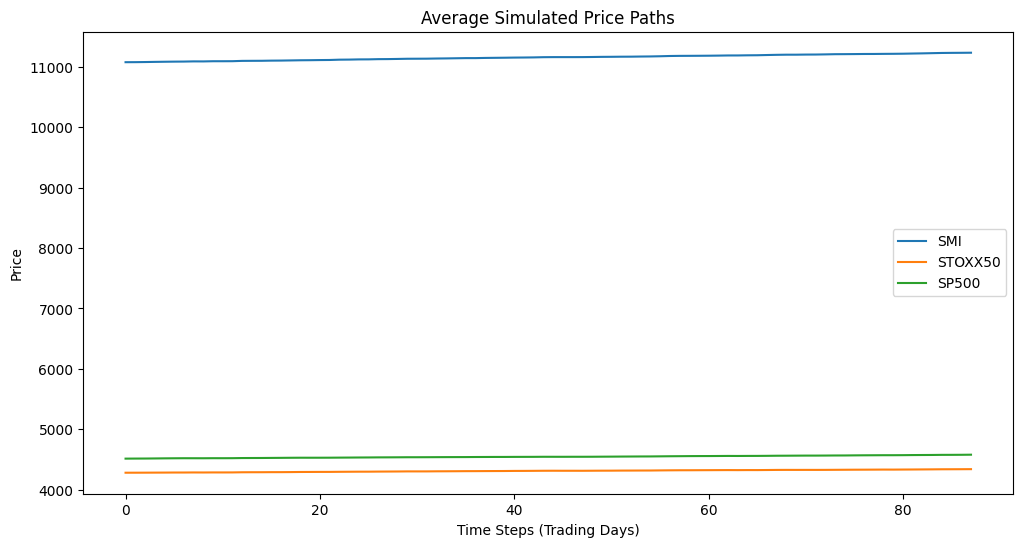

In [39]:
plt.figure(figsize=(12, 6))
time_steps = np.arange(n_timesteps + 1) * dt * 252  # Convert to trading days

for index in ['SMI', 'STOXX50', 'SP500']:
    average_price = price_paths[index].mean(axis=0)
    plt.plot(time_steps, average_price, label=index)

plt.title('Average Simulated Price Paths')
plt.xlabel('Time Steps (Trading Days)')
plt.ylabel('Price')
plt.legend()
plt.show()

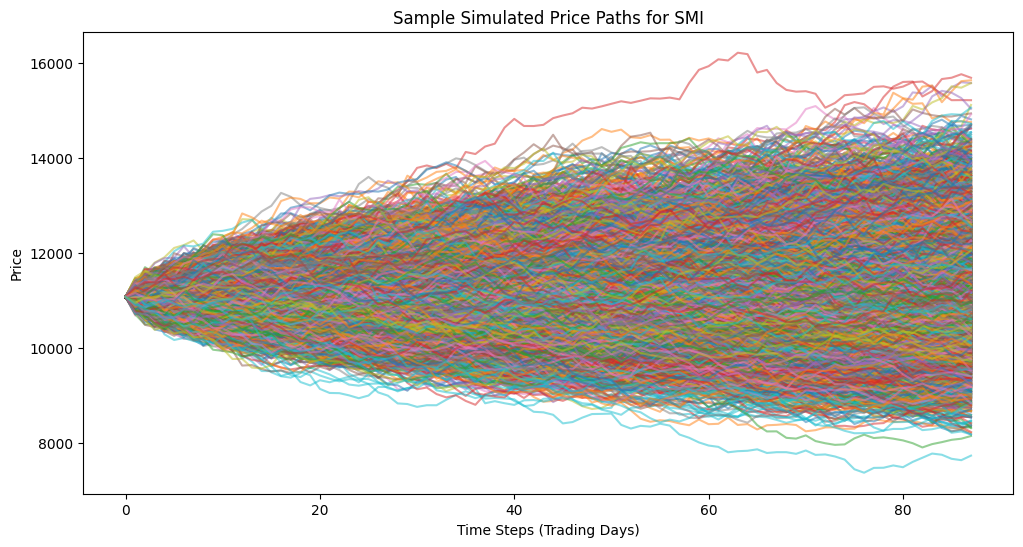

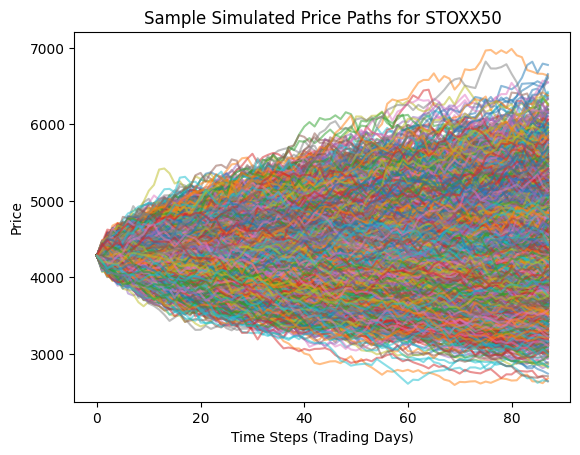

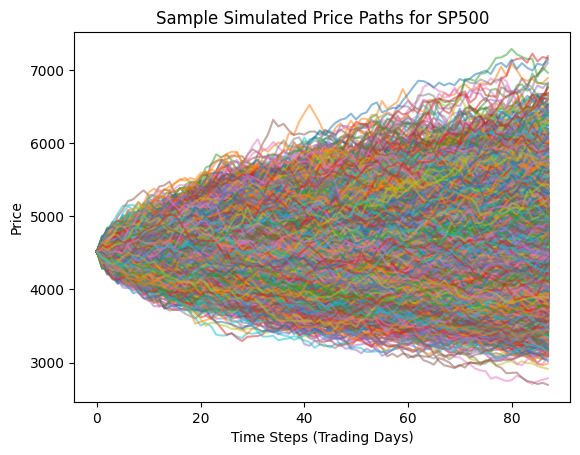

In [40]:
plt.figure(figsize=(12, 6))
num_paths_to_plot = 10000  # Number of paths to plot for each index

for index in ['SMI', 'STOXX50', 'SP500']:
    for i in range(num_paths_to_plot):
        plt.plot(time_steps, price_paths[index][i], alpha=0.5)
    plt.title(f'Sample Simulated Price Paths for {index}')
    plt.xlabel('Time Steps (Trading Days)')
    plt.ylabel('Price')
    plt.show()

In [41]:
def empirical_martingale_correction(price_data, r):
    price_data_new = {}
    
    for i in price_data:
        s = price_data.get(i)
        Z = np.zeros_like(s)
        s_ = np.zeros_like(s)
        s_[:,0] = s[:,0]
        r = np.log(1.03)
        for j in range(1, s.shape[1]):
            t_j = j * dt
            Z[:, j] = (s_[:, j-1] / s[:, j-1]) * s[:, j]
            Z_sum = np.average(Z[:, j], axis=0)
            Z0_j = np.exp(-r * t_j) * Z_sum
            s_[:, j] = s[:, 0] * Z[:, j] / Z0_j
        price_data_new[i] = s_
    return price_data_new
        

## Pricing

In [42]:
# final_date = pd.to_datetime('2024-09-26')
# start_date = pd.to_datetime('2023-09-01')
# dates = pd.bdate_range(start = start_date, end = '2024-01-01')
# price_chart = pd.DataFrame({"Start_Date":[], "GBM_Mean_Price":[], "GBM_Mean_Price_EMcorrection":[], "CIR_Mean_Price":[]})
# for start_date in dates:
#     nsim = 1000
#     sigma = {}
#     for index in ['SMI', 'STOXX50', 'SP500']:
#         #variance = returns[index].var(ddof= 1)*252
#         t = vol_index.get(index)
#         vol = t[t.index > start_date].iloc[-1].item()
#         sigma[index] = vol/100
        
#     price_paths = simulate_gbm(start_date, n_simulations= nsim)
#     gbm = price_barrier_reverse_convertible(start_date = start_date, price_paths=price_paths)
    
#     price_paths = empirical_martingale_correction(price_paths, r[r.index == start_date])
#     GBM_EMcorrection = price_barrier_reverse_convertible(start_date = start_date, price_paths=price_paths)
    
#     price_paths, _ = simulate_price_paths_with_CIR(start_date, n_simulations= nsim)
#     cir = price_barrier_reverse_convertible(start_date = start_date, price_paths=price_paths)
    
#     price_chart.loc[len(price_chart)+1] = {"Start_Date": start_date, "GBM_Mean_Price": np.mean(gbm), "GBM_Mean_Price_EMcorrection": np.mean(GBM_EMcorrection), "CIR_Mean_Price": np.mean(cir)}
#     print(start_date)
# price_chart.set_index("Start_Date", inplace = True)


In [46]:
price_chart = pd.DataFrame({
    "Start_Date": [], 
    "av_data": [],
})

# Define time range and parameters
final_date = pd.to_datetime('2024-09-26')
start_date = pd.to_datetime('2023-09-01')
dates = pd.bdate_range(start=start_date, end='2024-01-01')

nsim = 10000

for start_date in dates:
    sigma = {}
    for index in ['SMI', 'STOXX50', 'SP500']:
        t = vol_index.get(index)
        vol = t[t.index > start_date].iloc[-1].item()
        sigma[index] = vol / 100

    price_paths_av = simulate_gbm_with_av(start_date, n_simulations=nsim)
    av_data = price_barrier_reverse_convertible(start_date=start_date, price_paths=price_paths_av)

    # Update existing rows with Volatility Index-based volatility results
    price_chart.loc[len(price_chart)+1] = {
        "Start_Date": start_date,
        "av_data": np.mean(av_data)
    }
        

# Set the Start_Date as index
price_chart.set_index("Start_Date", inplace=True)
price_chart.to_csv("overnight_price_chart.csv")


Initial Interest Rate: 0.04094998632895417
Initial Interest Rate: 0.04094998632895417
Initial Interest Rate: 0.04181350281341035
Initial Interest Rate: 0.042101176018635326
Initial Interest Rate: 0.04181350281341035
Initial Interest Rate: 0.04171759335186847
Initial Interest Rate: 0.04200529414503007
Initial Interest Rate: 0.04181350281341035
Initial Interest Rate: 0.04162167469081945
Initial Interest Rate: 0.04200529414503007
Initial Interest Rate: 0.04238876649178652
Initial Interest Rate: 0.042292912190251365
Initial Interest Rate: 0.042772091843869056
Initial Interest Rate: 0.04258044753511848
Initial Interest Rate: 0.043921187057928086
Initial Interest Rate: 0.043442557842836724
Initial Interest Rate: 0.044495239886551304
Initial Interest Rate: 0.04459088332787522
Initial Interest Rate: 0.045068963367578145
Initial Interest Rate: 0.0448777587780855
Initial Interest Rate: 0.0448777587780855
Initial Interest Rate: 0.04583341634317215
Initial Interest Rate: 0.04697900119399464
Initia

In [47]:
price_chart

av_data
Start_Date             
2023-09-01  1078.807037
2023-09-04  1079.372159
2023-09-05  1078.594127
2023-09-06  1078.405221
2023-09-07  1078.909922
...                 ...
2023-12-26  1070.160457
2023-12-27  1071.012206
2023-12-28  1070.752659
2023-12-29  1070.569561
2024-01-01  1070.904565

[87 rows x 1 columns]

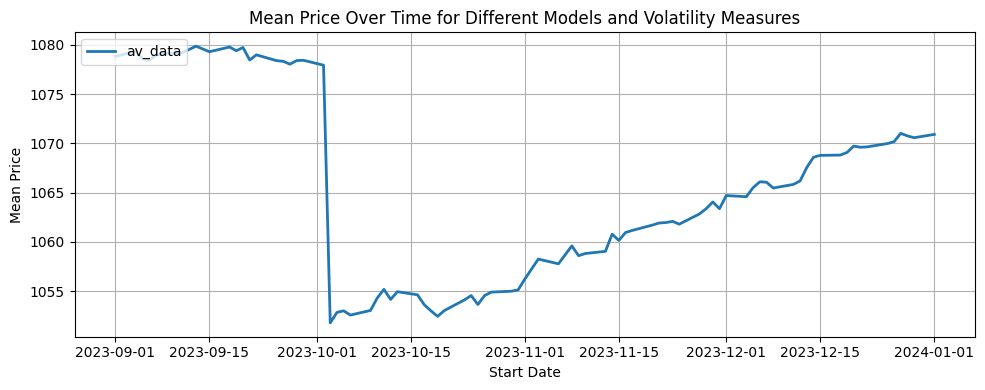

In [49]:
def plot_price_chart(price_chart):
    plt.figure(figsize=(10, 4))
    
    # Iterate over each column and plot it
    for column in price_chart.columns:
        plt.plot(price_chart.index, price_chart[column], label=column, linewidth=2)
    
    plt.xlabel('Start Date')
    plt.ylabel('Mean Price')
    plt.title('Mean Price Over Time for Different Models and Volatility Measures')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Call the function with the price_chart dataframe
plot_price_chart(price_chart)

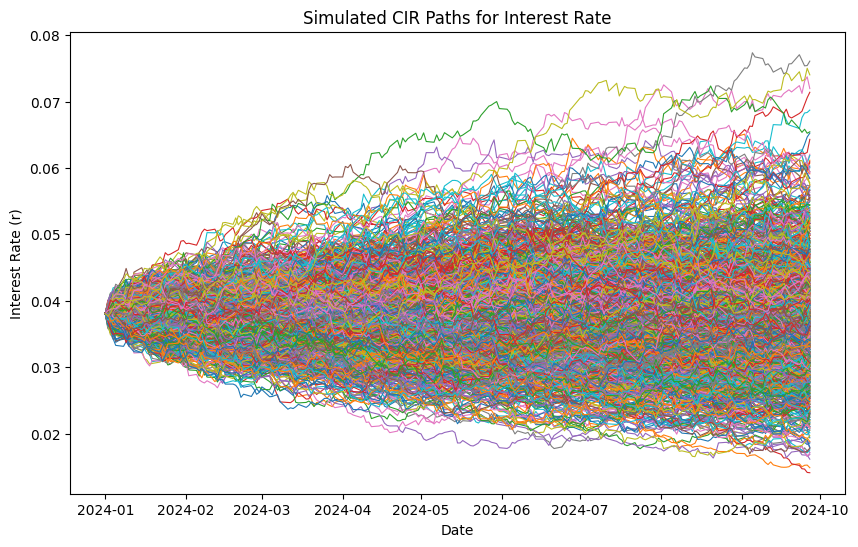

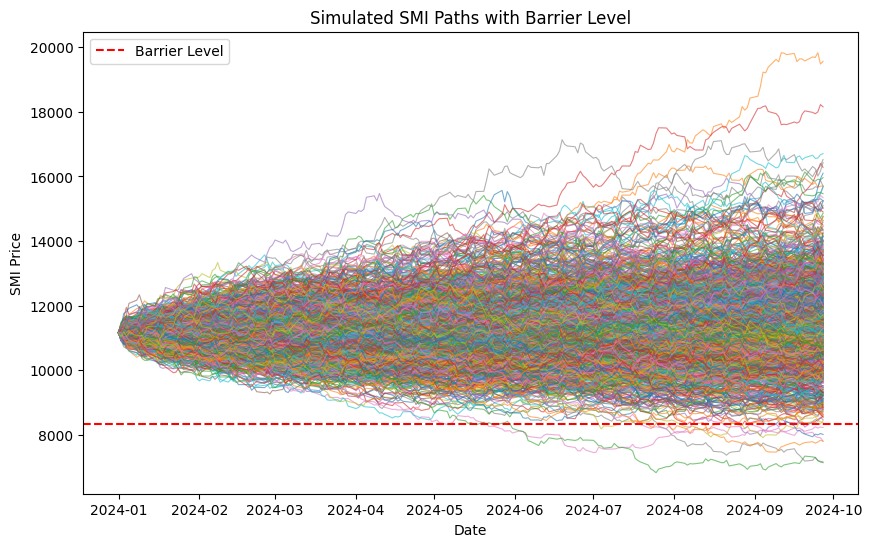

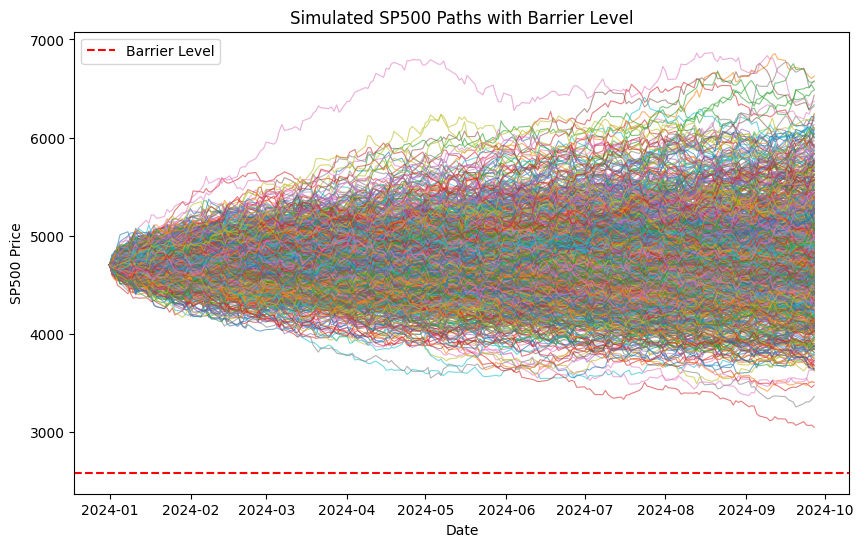

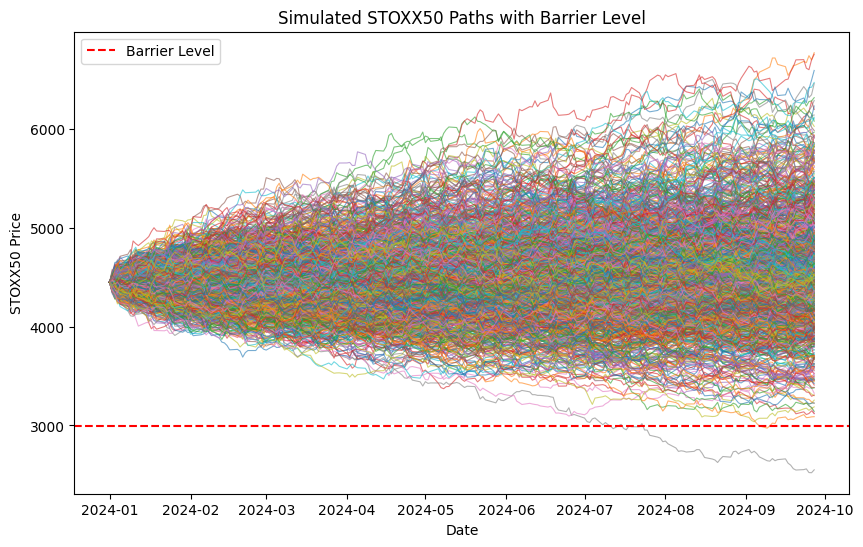

In [ ]:
## Checking if model is working correctly. 

start_date = pd.to_datetime('2024-01-01')
dates = pd.bdate_range(start = start_date, end = final_date+pd.to_timedelta("1d"))
n_simulations = 1000
price_paths, r_paths = simulate_price_paths_with_CIR(start_date, n_simulations= n_simulations)
n_timesteps = len(dates)


sp500_init_level = 3977
stoxx_init_level = 4164
smi_init_level= 10786

eur_usd = eur["Price"][start_date] 
chf_usd = chf["Price"][start_date] 
stoxx_init_level = stoxx_init_level_local / eur_usd
smi_init_level = smi_init_level_local / chf_usd
sp500_barrier = sp500_init_level * 0.65
stoxx_barrier = stoxx_init_level * 0.65
smi_barrier = smi_init_level * 0.65
import matplotlib.pyplot as plt

# --- Plot Interest Rate Paths ---
plt.figure(figsize=(10, 6))
for i in range(n_simulations-1):
    plt.plot(dates, r_paths.transpose()[i], lw=0.8)
plt.xlabel("Date")
plt.ylabel("Interest Rate (r)")
plt.title("Simulated CIR Paths for Interest Rate")
plt.show()

# --- Plot SMI Price Paths with Barrier Line ---
plt.figure(figsize=(10, 6))
for i in range(n_simulations-1):
    plt.plot(dates, price_paths['SMI'][i, :], lw=0.8, alpha=0.6)
# Add barrier line
plt.axhline(y=smi_barrier, color='r', linestyle='--', label='Barrier Level')
plt.xlabel("Date")
plt.ylabel("SMI Price")
plt.title("Simulated SMI Paths with Barrier Level")
plt.legend()
plt.show()

# --- Plot SP500 Price Paths with Barrier Line ---
plt.figure(figsize=(10, 6))
for i in range(n_simulations-1):
    plt.plot(dates, price_paths['SP500'][i, :], lw=0.8, alpha=0.6)
# Add barrier line
plt.axhline(y=sp500_barrier, color='r', linestyle='--', label='Barrier Level')
plt.xlabel("Date")
plt.ylabel("SP500 Price")
plt.title("Simulated SP500 Paths with Barrier Level")
plt.legend()
plt.show()

# --- Plot STOXX50 Price Paths with Barrier Line ---
plt.figure(figsize=(10, 6))
for i in range(n_simulations-1):
    plt.plot(dates, price_paths['STOXX50'][i, :], lw=0.8, alpha=0.6)
# Add barrier line
plt.axhline(y=stoxx_barrier, color='r', linestyle='--', label='Barrier Level')
plt.xlabel("Date")
plt.ylabel("STOXX50 Price")
plt.title("Simulated STOXX50 Paths with Barrier Level")
plt.legend()
plt.show()

In [ ]:
x = price_barrier_reverse_convertible(start_date = start_date, price_paths=price_paths)
np.mean(x)

np.float64(1066.9756927116177)

## Delta Calculation

In [ ]:
final_date = pd.to_datetime('2024-09-26')
start_date = pd.to_datetime('2023-09-01')
dates = pd.bdate_range(start = start_date, end = '2024-01-01')
delta_chart = pd.DataFrame({"Start_Date":[], "sp500_delta":[], "smi_delta":[], "stoxx50_delta":[]})
h = {'SMI': 1.0,'STOXX50':1.0, 'SP500':1.0}
price_data = {
        'SMI': smi,
        'STOXX50': stoxx50,
        'SP500': sp500
    }
    
for start_date in dates:
    if start_date in delta_chart["Start_Date"]: continue 
    nsim = 200000
    sigma = {}
    for index in ['SMI', 'STOXX50', 'SP500']:
        #variance = returns[index].var(ddof= 1)*252
        t = vol_index.get(index)
        vol = t[t.index > start_date].iloc[-1].item()
        sigma[index] = vol/100
    h = {'SMI': 1.0,'STOXX50':1.0, 'SP500':1.0}
    deltas = {}
    initial_prices = {}
    for index in price_data:
        initial_prices[index] = price_data[index]['Price'][price_data[index].index >= start_date].iloc[-1]
    for i in h:
        h = {'SMI': 1.0,'STOXX50':1.0, 'SP500':1.0}
        h_percent = 0.05
        h[i] = 1.0 + h_percent
        price_paths, _ = simulate_price_paths_with_CIR(start_date, n_simulations= nsim, h_percentage_change= h)
        cir = price_barrier_reverse_convertible(start_date = start_date, price_paths=price_paths)
        upper_price = np.mean(cir)
        h[i] = 1.0 - h_percent
        price_paths, _ = simulate_price_paths_with_CIR(start_date, n_simulations= nsim, h_percentage_change= h)
        cir = price_barrier_reverse_convertible(start_date = start_date, price_paths=price_paths)
        lower_price = np.mean(cir)
        epsilon = initial_prices.get(i)*h_percent
        deltas[i] = (upper_price-lower_price)/(2*epsilon)

    delta_chart.loc[len(delta_chart)+1] = {"Start_Date": start_date, 
                                           "sp500_delta":deltas.get("SP500"), 
                                           "smi_delta":deltas.get("SMI"), 
                                           "stoxx50_delta":deltas.get("STOXX50")}
    print(start_date)


#Needs to have 5000> sims for vaguely accurate results
delta_chart.to_csv("delta_chart_overnight.csv")

IndexError: single positional indexer is out-of-bounds

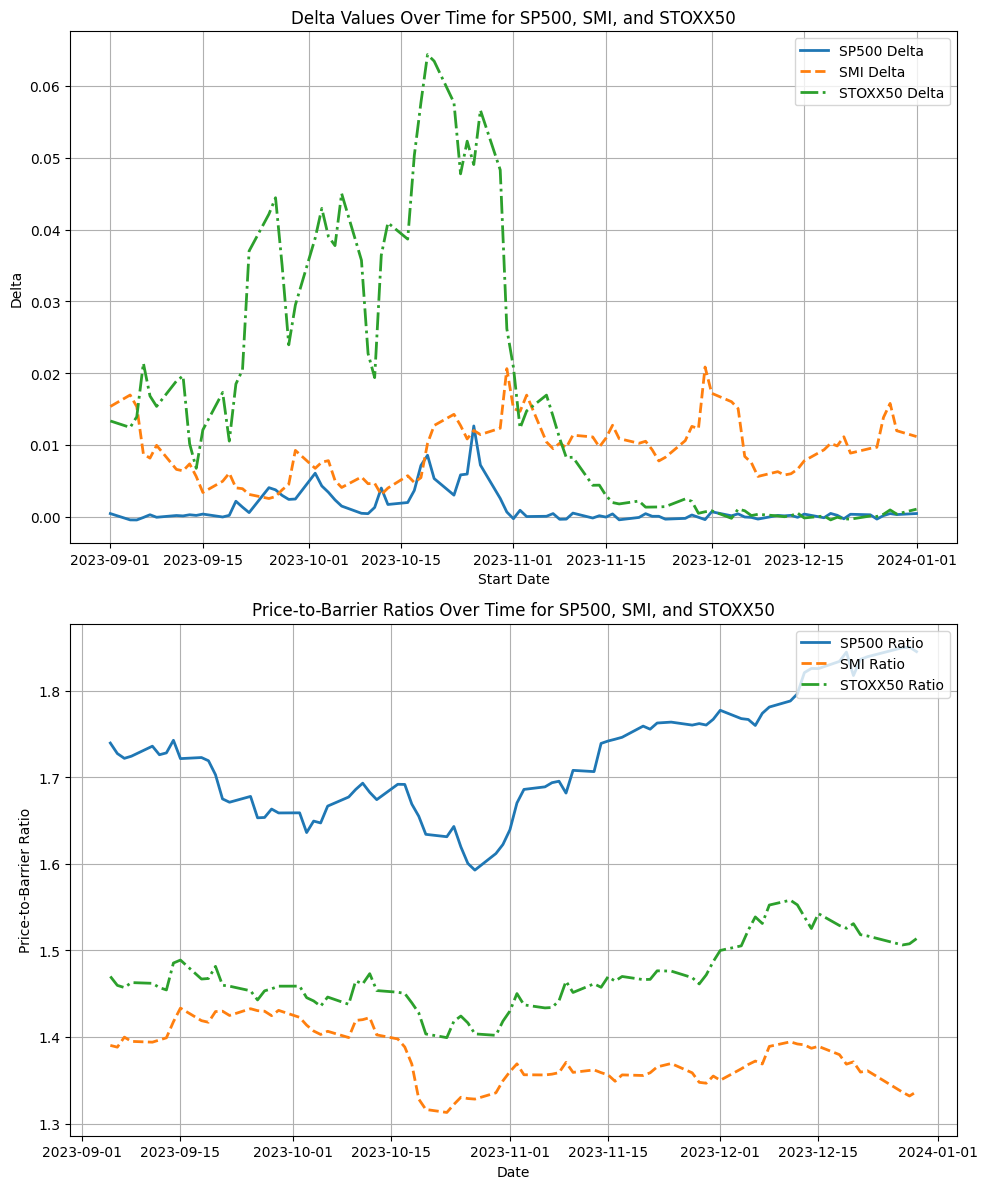

In [ ]:
#delta_chart.set_index("Start_Date", inplace = True)
#Might have to comment out if already set
sp500_init_level = 3977
stoxx_init_level = 4164
smi_init_level= 10786

delta_chart.rename(columns={"sp500_delta":"SP500", 	"smi_delta"	: "SMI", "stoxx50_delta":"STOXX50"}, inplace = True)

start_date = pd.to_datetime('2023-09-01')
end_date = pd.to_datetime('2024-01-01')

# Step 2: Filter the data for the specified timeframe
smi1 = smi[(smi.index > start_date) & (smi.index < end_date)]["Price"]
stoxx501 = stoxx50[(stoxx50.index > start_date) & (stoxx50.index < end_date)]["Price"]
sp5001 = sp500[(sp500.index > start_date) & (sp500.index < end_date)]["Price"]

# Step 3: Calculate the barriers
smi_barrier_df = smi_init_level * 0.65 / chf["Price"]
stoxx50_barrier_df = stoxx_init_level * 0.65 / eur["Price"]
sp500_barrier_df = sp500_barrier  # Assuming `sp500_barrier` contains the barrier price directly

# Step 4: Align filtered data with respective barriers
smi_filtered = smi1[smi1.index.isin(smi_barrier_df.index)]
smi_barrier_filtered = smi_barrier_df[smi_barrier_df.index.isin(smi_filtered.index)]

stoxx50_filtered = stoxx501[stoxx501.index.isin(stoxx50_barrier_df.index)]
stoxx50_barrier_filtered = stoxx50_barrier_df[stoxx50_barrier_df.index.isin(stoxx50_filtered.index)]


# Step 5: Calculate the ratios of price to barrier
smi_ratio = smi_filtered / smi_barrier_filtered
stoxx50_ratio = stoxx50_filtered / stoxx50_barrier_filtered
sp500_ratio = sp500["Price"] / sp500_barrier

# Combine the ratios into a DataFrame for easier comparison
ratios_df = pd.DataFrame({
    "SMI Price-to-Barrier Ratio": smi_ratio,
    "STOXX50 Price-to-Barrier Ratio": stoxx50_ratio,
    "SP500 Price-to-Barrier Ratio": sp500_ratio
}).dropna()

# Display the combined DataFrame
ratios_df
def plot_delta_chart_with_ratios(delta_chart):
    plt.figure(figsize=(10, 12))

    # First Plot: Delta Chart
    plt.subplot(2, 1, 1)
    plt.plot(delta_chart.index, delta_chart['SP500'], label='SP500 Delta', linestyle='-', linewidth=2)
    plt.plot(delta_chart.index, delta_chart['SMI'], label='SMI Delta', linestyle='--', linewidth=2)
    plt.plot(delta_chart.index, delta_chart['STOXX50'], label='STOXX50 Delta', linestyle='-.', linewidth=2)
    plt.xlabel('Start Date')
    plt.ylabel('Delta')
    plt.title('Delta Values Over Time for SP500, SMI, and STOXX50')
    plt.legend(loc='upper right')
    plt.grid(True)

    # Second Plot: Ratios Chart
    plt.subplot(2, 1, 2)
    plt.plot(ratios_df.index, ratios_df['SP500 Price-to-Barrier Ratio'], label='SP500 Ratio', linestyle='-', linewidth=2)
    plt.plot(ratios_df.index, ratios_df['SMI Price-to-Barrier Ratio'], label='SMI Ratio', linestyle='--', linewidth=2)
    plt.plot(ratios_df.index, ratios_df['STOXX50 Price-to-Barrier Ratio'], label='STOXX50 Ratio', linestyle='-.', linewidth=2)
    plt.xlabel('Date')
    plt.ylabel('Price-to-Barrier Ratio')
    plt.title('Price-to-Barrier Ratios Over Time for SP500, SMI, and STOXX50')
    plt.legend(loc='upper right')
    plt.grid(True)

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()


    # Step 1: Define the timeframe


    
plot_delta_chart_with_ratios(delta_chart)

## Delta Hedging 

In [ ]:
from sklearn.decomposition import PCA
delta_chart.rename(columns={"sp500_delta":"SP500", 	"smi_delta"	: "SMI", "stoxx50_delta":"STOXX50"}, inplace = True)
returns_diff = pd.DataFrame({"SP500": list(sp500["Price"] - sp500["Price"].shift(1)), 
                            "SMI": list(smi["Price"] - smi["Price"].shift(1)), 
                            "STOXX50": list(stoxx50["Price"] - stoxx50["Price"].shift(1))})
cov_matrix = returns.cov()

cov_array = cov_matrix.values
n_components = 1
pca = PCA(n_components=n_components)

pca.fit(cov_array)
eigenvalues = pca.explained_variance_
eigenvectors = pca.components_.T  
print("Explained Variance:", pca.explained_variance_ratio_)
delta_factor = eigenvectors.T @ delta_chart[["SP500","SMI","STOXX50"]].values[0]
## so delta for each factor in pca
print("Delta Factor:",delta_factor)
hedge_positions_factor = -delta_factor
hedge_positions_asset = eigenvectors @ hedge_positions_factor
print("Orignal Hedge:", -delta_chart[["SP500","SMI","STOXX50"]].values[0])
print("Updated Hedge:", hedge_positions_asset)
print("Ignore the first one, i.e no need to hold S&P500 at current levels")
notional_amount = 1000  

Explained Variance: [0.68023169]
Delta Factor: [0.00969754]
Orignal Hedge: [-0.00042375 -0.01534446 -0.01333064]
Updated Hedge: [ 0.00260296  0.00176831 -0.00917278]
Ignore the first one, i.e no need to hold S&P500 at current levels


In [3]:
import numpy as np
from scipy.stats import ortho_group

def generate_random_C(d):
    A = ortho_group.rvs(d)
    
    num_half = d // 2
    eigenvalues = np.array([0.1] * num_half + [1.0] * (d - num_half))
    
    # Shuffle eigenvalues to randomise
    np.random.shuffle(eigenvalues)
    
    # Construct the diagonal matrix D
    D = np.diag(eigenvalues)
    
    C = A.T @ D @ A  
    
    return C

# Example usage:
d = 5  # Dimension of the matrix
C = generate_random_C(d)

print("Generated matrix C:")
print(C)

# Verify that C is positive-definite by checking its eigenvalues
eigenvalues_C = np.linalg.eigvalsh(C)
print("\nEigenvalues of C:")
print(eigenvalues_C)

Generated matrix C:
[[ 0.41027763  0.1974483  -0.07092668 -0.08953928 -0.36186178]
 [ 0.1974483   0.5268579  -0.26692156 -0.30050295  0.03780826]
 [-0.07092668 -0.26692156  0.78389827 -0.24677151 -0.10304225]
 [-0.08953928 -0.30050295 -0.24677151  0.71807701 -0.12261579]
 [-0.36186178  0.03780826 -0.10304225 -0.12261579  0.76088919]]

Eigenvalues of C:
[0.1 0.1 1.  1.  1. ]


In [30]:
import numpy as np

def bandit_algorithm(d, num_iterations, n_samples, alpha, sigma, seed=None):
    if seed is not None:
        np.random.seed(seed)

    # Initialize policy parameter theta
    theta = np.zeros(d)
    theta_history = [theta.copy()]
    reward_history = []

    # True parameters (unknown to the learner)
    a_star = np.full(d, 4.0)  # Optimal action
    # Generate matrix C with eigenvalues 0.1 and 1 (from previous question)
    C = generate_random_C(d)

    for k in range(num_iterations):
        # Data collection
        actions = []
        rewards = []
        X = []

        for t in range(n_samples):
            # Sample action from stochastic policy
            a_t = np.random.multivariate_normal(theta, sigma**2 * np.eye(d))

            # Observe reward (simulated environment)
            delta = a_t - a_star
            r_t = - delta.T @ C @ delta

            # Compute feature vector
            x_t = np.hstack((a_t - theta, 1))

            # Store data
            actions.append(a_t)
            rewards.append(r_t)
            X.append(x_t)

        X = np.array(X)  # Shape: (n_samples, d + 1)
        r = np.array(rewards)  # Shape: (n_samples,)

        # Linear regression to estimate psi
        # Add small regularization term for numerical stability
        lambda_reg = 1e-8
        XtX = X.T @ X + lambda_reg * np.eye(d + 1)
        XtX_inv = np.linalg.inv(XtX)
        Xtr = X.T @ r
        psi_hat = XtX_inv @ Xtr  # Shape: (d + 1,)

        # Update theta
        theta += alpha * psi_hat[:d]

        # Store theta and average reward
        theta_history.append(theta.copy())
        avg_reward = np.mean(rewards)
        reward_history.append(avg_reward)

        # Optional: Print progress
        print(f"Iteration {k+1}/{num_iterations}, Avg Reward: {avg_reward:.4f}")

    return theta_history, reward_history

def generate_random_C(d):
    # Function from the previous assistant's answer
    from scipy.stats import ortho_group

    # Generate a random orthogonal matrix A
    A = ortho_group.rvs(d)

    # Determine counts for eigenvalues
    num_ones = d // 2
    num_point_ones = d - num_ones  # Ensures total count is d

    # Create eigenvalues array
    eigenvalues = np.array([0.1] * num_point_ones + [1.0] * num_ones)

    # Shuffle eigenvalues
    np.random.shuffle(eigenvalues)

    # Construct diagonal matrix D
    D = np.diag(eigenvalues)

    # Compute matrix C
    C = A.T @ D @ A

    return C

# Example usage:
d = 5  # Dimension of action space
num_iterations = 300
n_samples = 50  # Number of samples per iteration
alpha = 0.1
sigma = 1.0
seed = 42

theta_history, reward_history = bandit_algorithm(d, num_iterations, n_samples, alpha, sigma, seed)

Iteration 1/300, Avg Reward: -27.3339
Iteration 2/300, Avg Reward: -18.2890
Iteration 3/300, Avg Reward: -17.1338
Iteration 4/300, Avg Reward: -11.4611
Iteration 5/300, Avg Reward: -10.4596
Iteration 6/300, Avg Reward: -9.3113
Iteration 7/300, Avg Reward: -8.4242
Iteration 8/300, Avg Reward: -7.9204
Iteration 9/300, Avg Reward: -7.6967
Iteration 10/300, Avg Reward: -6.3360
Iteration 11/300, Avg Reward: -6.3641
Iteration 12/300, Avg Reward: -6.5955
Iteration 13/300, Avg Reward: -6.1716
Iteration 14/300, Avg Reward: -6.2205
Iteration 15/300, Avg Reward: -6.0534
Iteration 16/300, Avg Reward: -6.0383
Iteration 17/300, Avg Reward: -5.5916
Iteration 18/300, Avg Reward: -5.5294
Iteration 19/300, Avg Reward: -5.1800
Iteration 20/300, Avg Reward: -5.4890
Iteration 21/300, Avg Reward: -4.6181
Iteration 22/300, Avg Reward: -4.8589
Iteration 23/300, Avg Reward: -4.6789
Iteration 24/300, Avg Reward: -5.7364
Iteration 25/300, Avg Reward: -4.7430
Iteration 26/300, Avg Reward: -4.8892
Iteration 27/300

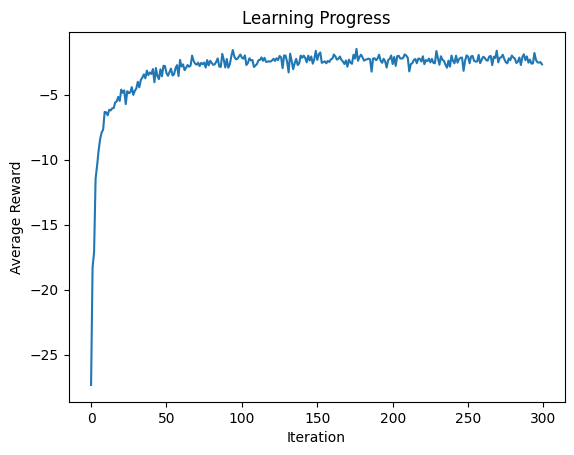

In [31]:
import matplotlib.pyplot as plt

plt.plot(reward_history)
plt.xlabel('Iteration')
plt.ylabel('Average Reward')
plt.title('Learning Progress')
plt.show()

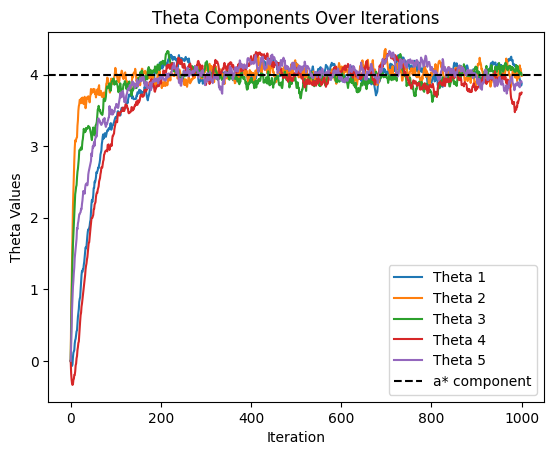

In [20]:
theta_array = np.array(theta_history)
for i in range(d):
    plt.plot(theta_array[:, i], label=f'Theta {i+1}')
plt.axhline(4.0, color='k', linestyle='--', label='a* component')
plt.xlabel('Iteration')
plt.ylabel('Theta Values')
plt.title('Theta Components Over Iterations')
plt.legend()
plt.show()

In [54]:
import numpy as np
import matplotlib.pyplot as plt

def reinforce_algorithm(d, num_iterations, alpha, sigma, seed=None):
    """
    Implements the REINFORCE algorithm with a Gaussian policy.

    Parameters:
    - d: Dimension of the action space.
    - num_iterations: Number of iterations to run the algorithm.
    - alpha: Learning rate.
    - sigma: Standard deviation of the Gaussian policy.
    - seed: Random seed for reproducibility.

    Returns:
    - theta_history: History of theta updates.
    - reward_history: History of rewards per iteration.
    """
    if seed is not None:
        np.random.seed(seed)

    # Initialize policy parameter theta
    theta = np.zeros(d)
    theta_history = [theta.copy()]
    reward_history = []

    # True parameters (unknown to the learner)
    a_star = np.full(d, 4.0)  # Optimal action
    C = generate_random_C(d)   # Positive-definite matrix from previous code
    num_samples_per_iteration = 10  # Adjust as needed

    for t in range(num_iterations):
        grad_log_policy = np.zeros(d)
        total_reward = 0.0

        for _ in range(num_samples_per_iteration):
            a_t = np.random.multivariate_normal(theta, sigma**2 * np.eye(d))
            delta = a_t - a_star
            r_t = - delta.T @ C @ delta
            grad_log_policy += (a_t - theta) / (sigma**2) * r_t
            total_reward += r_t

        grad_log_policy /= num_samples_per_iteration
        theta += alpha * grad_log_policy
        avg_reward = total_reward / num_samples_per_iteration
        # Store and print as before
        # Observe reward (simulated environment)
        delta = a_t - a_star
        r_t = - delta.T @ C @ delta

        # Compute policy gradient
        grad_log_policy = (a_t - theta) / (sigma**2)

        # Update theta
        theta += alpha * grad_log_policy * r_t

        # Store theta and reward
        theta_history.append(theta.copy())
        reward_history.append(r_t)

        # Optional: Print progress
        if (t+1) % 10 == 0 or t == 0:
            avg_reward = np.mean(reward_history[-10:])
            print(f"Iteration {t+1}/{num_iterations}, Reward: {r_t:.4f}, Avg Reward (last 10): {avg_reward:.4f}")

    return theta_history, reward_history

def generate_random_C(d):
    # Function from the previous assistant's answer
    from scipy.stats import ortho_group

    # Generate a random orthogonal matrix A
    A = ortho_group.rvs(d)

    # Determine counts for eigenvalues
    num_ones = d // 2
    num_point_ones = d - num_ones  # Ensures total count is d

    # Create eigenvalues array
    eigenvalues = np.array([0.1] * num_point_ones + [1.0] * num_ones)

    # Shuffle eigenvalues
    np.random.shuffle(eigenvalues)

    # Construct diagonal matrix D
    D = np.diag(eigenvalues)

    # Compute matrix C
    C = A.T @ D @ A

    return C

# Example usage:
d = 5  # Dimension of action space
num_iterations = 1000
alpha = 0.01
sigma = 1.0
seed = 42

theta_history_reinforce, reward_history_reinforce = reinforce_algorithm(d, num_iterations, alpha, sigma, seed)

Iteration 1/1000, Reward: -33.2757, Avg Reward (last 10): -33.2757
Iteration 10/1000, Reward: -22.3739, Avg Reward (last 10): -20.8057
Iteration 20/1000, Reward: -5.1493, Avg Reward (last 10): -16.3265
Iteration 30/1000, Reward: -15.4325, Avg Reward (last 10): -16.4737
Iteration 40/1000, Reward: -23.1092, Avg Reward (last 10): -11.8420
Iteration 50/1000, Reward: -4.9091, Avg Reward (last 10): -8.0285
Iteration 60/1000, Reward: -11.6214, Avg Reward (last 10): -9.7971
Iteration 70/1000, Reward: -7.6221, Avg Reward (last 10): -8.6043
Iteration 80/1000, Reward: -6.7925, Avg Reward (last 10): -8.7010
Iteration 90/1000, Reward: -8.0129, Avg Reward (last 10): -5.3551
Iteration 100/1000, Reward: -7.1172, Avg Reward (last 10): -6.3635
Iteration 110/1000, Reward: -2.9199, Avg Reward (last 10): -4.0914
Iteration 120/1000, Reward: -1.5308, Avg Reward (last 10): -5.5740
Iteration 130/1000, Reward: -3.4604, Avg Reward (last 10): -5.3227
Iteration 140/1000, Reward: -3.1106, Avg Reward (last 10): -4.1

In [55]:
# Assuming the function bandit_algorithm is defined as before

theta_history_lr, reward_history_lr = bandit_algorithm(
    d=d,
    num_iterations=num_iterations,  # Adjusted for similar runtime
    n_samples=10,  # Number of samples per iteration
    alpha=0.1,
    sigma=sigma,
    seed=seed
)

Iteration 1/1000, Avg Reward: -29.0231
Iteration 2/1000, Avg Reward: -19.3940
Iteration 3/1000, Avg Reward: -14.4255
Iteration 4/1000, Avg Reward: -13.1406
Iteration 5/1000, Avg Reward: -10.8768
Iteration 6/1000, Avg Reward: -6.9538
Iteration 7/1000, Avg Reward: -7.5570
Iteration 8/1000, Avg Reward: -7.6429
Iteration 9/1000, Avg Reward: -9.7518
Iteration 10/1000, Avg Reward: -8.3993
Iteration 11/1000, Avg Reward: -8.4125
Iteration 12/1000, Avg Reward: -6.4498
Iteration 13/1000, Avg Reward: -8.8855
Iteration 14/1000, Avg Reward: -6.5169
Iteration 15/1000, Avg Reward: -5.9747
Iteration 16/1000, Avg Reward: -4.6134
Iteration 17/1000, Avg Reward: -5.5233
Iteration 18/1000, Avg Reward: -4.3959
Iteration 19/1000, Avg Reward: -5.2003
Iteration 20/1000, Avg Reward: -5.2191
Iteration 21/1000, Avg Reward: -5.8664
Iteration 22/1000, Avg Reward: -4.5781
Iteration 23/1000, Avg Reward: -5.3421
Iteration 24/1000, Avg Reward: -4.8421
Iteration 25/1000, Avg Reward: -5.4540
Iteration 26/1000, Avg Reward

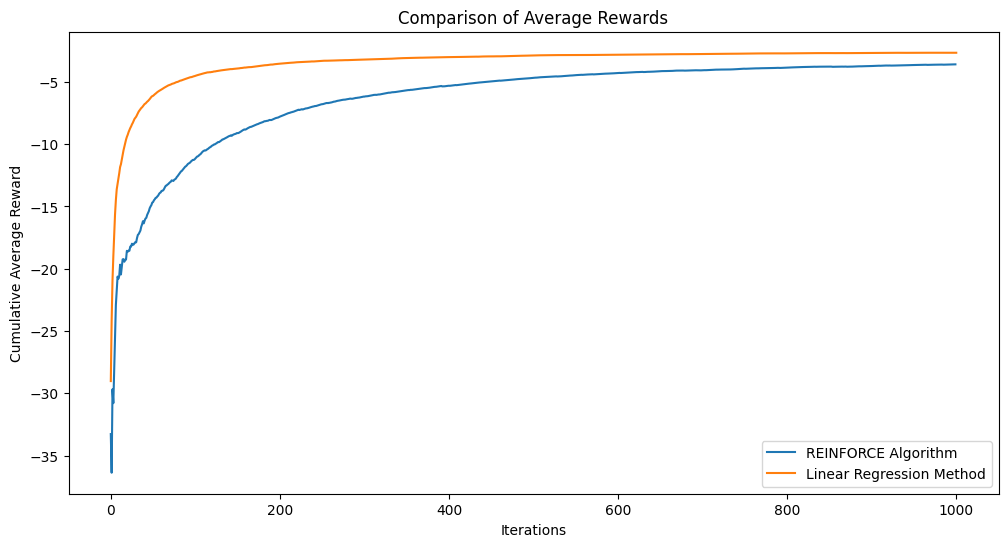

In [56]:
# Compute cumulative average rewards
cumulative_rewards_reinforce = np.cumsum(reward_history_reinforce) / np.arange(1, len(reward_history_reinforce) + 1)
cumulative_rewards_lr = np.cumsum(reward_history_lr) / np.arange(1, len(reward_history_lr) + 1)

# Plot average rewards
plt.figure(figsize=(12, 6))
plt.plot(cumulative_rewards_reinforce, label='REINFORCE Algorithm')
plt.plot(np.linspace(0, num_iterations, len(cumulative_rewards_lr)), cumulative_rewards_lr, label='Linear Regression Method')
plt.xlabel('Iterations')
plt.ylabel('Cumulative Average Reward')
plt.title('Comparison of Average Rewards')
plt.legend()
plt.show()

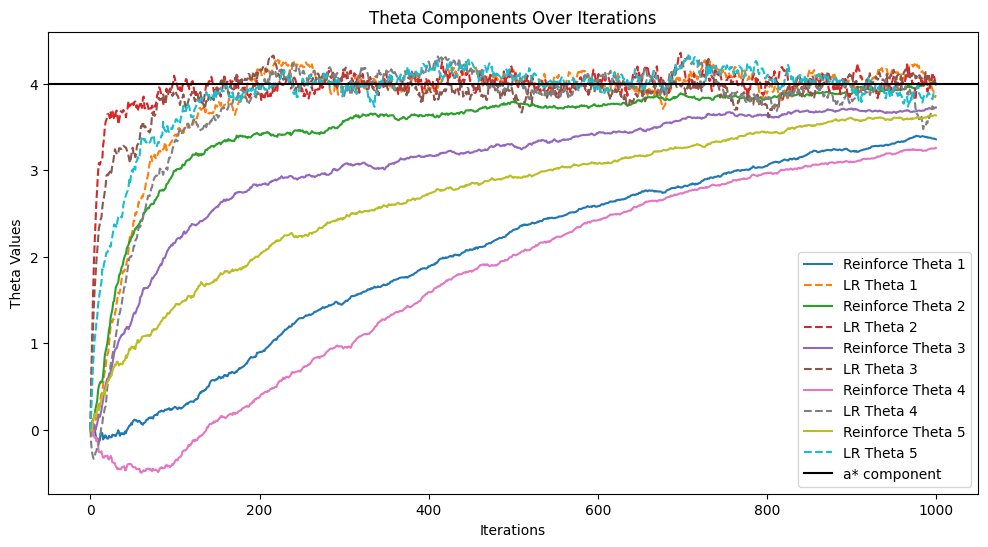

In [44]:
# Convert theta histories to arrays
theta_array_reinforce = np.array(theta_history_reinforce)
theta_array_lr = np.array(theta_history_lr)

# Plot theta components over iterations
plt.figure(figsize=(12, 6))
for i in range(d):
    plt.plot(theta_array_reinforce[:, i], label=f'Reinforce Theta {i+1}')
    plt.plot(np.linspace(0, num_iterations, len(theta_array_lr)), theta_array_lr[:, i], label=f'LR Theta {i+1}', linestyle='--')

plt.axhline(4.0, color='k', linestyle='-', label='a* component')
plt.xlabel('Iterations')
plt.ylabel('Theta Values')
plt.title('Theta Components Over Iterations')
plt.legend()
plt.show()